In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-03_16-51_20200101_20200831_lock_periods_by_8.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.002572347266881029

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

YM       0.25
ES       0.25
GC       0.25
NQ       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    -2874.1
GC    14507.2
NQ     8765.0
YM    18582.2
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

38980.29999999999

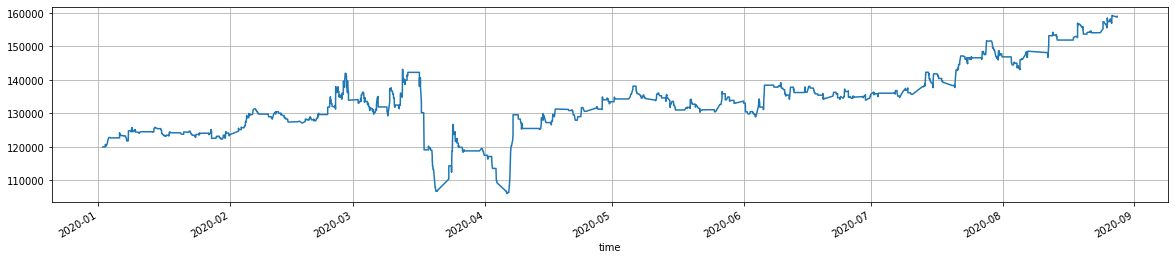

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    197
 GC    340
 NQ    800
 YM    218
 Name: action, dtype: int64,
 1555)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.145349
 GC    1.976744
 NQ    4.651163
 YM    1.267442
 Name: action, dtype: float64,
 9.040697674418604)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     413.7
GC     822.8
NQ    1680.0
YM     457.8
Name: commission, dtype: float64

In [16]:
df.commission.sum()

3374.3000000000006

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.42,21.91,710.12,-481.58,1.47,18.93,400.0
GC,0.36,85.34,1212.10,-561.51,2.16,76.99,170.0
YM,0.50,170.48,1237.10,-876.75,1.41,180.17,109.0
ES,0.38,-29.33,1635.33,-1039.04,1.57,-22.78,98.0
total,0.41,50.17,1001.46,-623.06,1.61,42.99,777.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.041055,0.244231,0.646876,0.775431
GC,0.041055,1.000000,-0.143812,0.024891,0.442590
NQ,0.244231,-0.143812,1.000000,0.115996,0.497338
YM,0.646876,0.024891,0.115996,1.000000,0.694201
total,0.775431,0.442590,0.497338,0.694201,1.000000


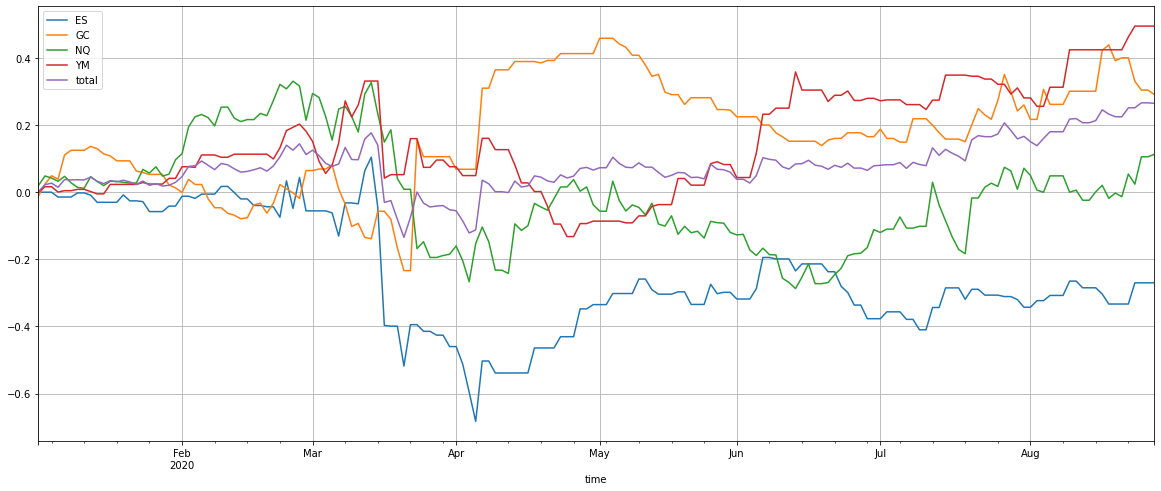

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

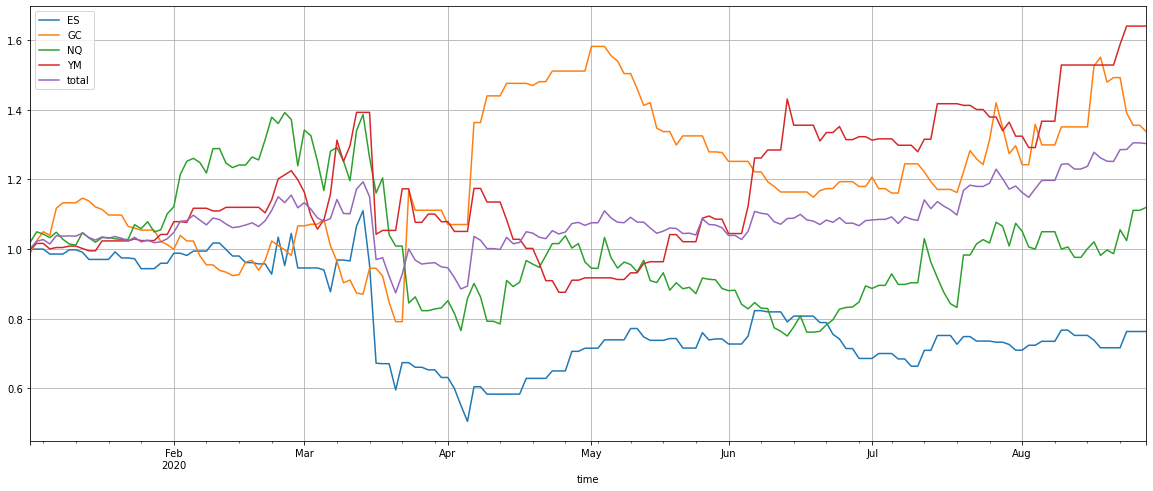

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.326745,0.531003,0.180185,1.065247,0.473976
Cumulative returns,-0.236647,0.337376,0.119718,0.640517,0.303171
Annual volatility,0.698968,0.815332,0.730325,0.595541,0.420440
Sharpe ratio,-0.200815,0.868961,0.586120,1.523829,1.131963
Calmar ratio,-0.599416,1.715456,0.390865,2.871668,1.771906
Stability,0.309977,0.336427,0.181712,0.456454,0.376399
Max drawdown,-0.545107,-0.309540,-0.460989,-0.370951,-0.267495
Omega ratio,0.947876,1.290969,1.113828,1.497937,1.268719
Sortino ratio,-0.274967,2.304411,0.909141,2.351674,1.807527
Skew,-1.020911,5.556572,0.467409,-0.731730,0.355180


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-4.06,1.29,10.15,4.21,2.97
2020-02-29,-1.41,5.30,12.51,15.08,8.63
2020-03-31,-33.26,4.21,-32.92,-10.05,-15.15
2020-04-30,13.32,35.96,15.87,-14.96,12.55
2020-05-31,3.73,-15.49,-7.91,18.37,-0.63
2020-06-30,-7.56,-7.62,0.83,21.81,1.91
2020-07-31,3.47,9.92,20.09,0.11,9.19
2020-08-31,7.56,3.11,4.25,23.88,10.33


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES      -24.0
GC       34.0
NQ       12.0
YM       64.0
total    30.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-04-07 02:34:00,GC,SELL,1725.00,8205.16
2020-03-24 11:58:30,GC,SELL,1679.70,7985.16
2020-03-12 14:57:30,ES,BUY,2556.00,6458.30
2020-03-24 06:35:30,GC,SELL,1585.10,6305.16
2020-04-07 16:16:30,ES,SELL,2694.25,5920.80
...,...,...,...,...
2020-03-20 07:41:30,ES,BUY,2423.50,-3366.70
2020-03-16 14:55:00,ES,BUY,2449.75,-4204.20
2020-03-17 16:09:30,ES,BUY,2454.50,-4241.70


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.197360,0.273505,0.050387,0.117553,0.159701
2020-03-24,0.000000,0.476344,-0.162033,0.000000,0.078578
2020-07-21,0.030277,0.050505,0.180773,-0.003307,0.064562
2020-03-12,0.103470,-0.040989,0.119940,0.073887,0.064077
2020-03-23,0.131527,0.000000,0.000000,0.113360,0.061222
...,...,...,...,...,...
2020-04-03,-0.080973,0.000000,-0.060780,0.000000,-0.035438
2020-03-16,-0.140140,0.085505,-0.089473,0.000000,-0.036027
2020-03-20,-0.112223,-0.065161,-0.030947,0.000000,-0.052083
